In [2]:
import numpy as np
import pandas as pd
from matplotlib.pylab import plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk

In [58]:
df=pd.read_csv('/Users/ravina/Desktop/FakeNewsClassifier/WELFake_Dataset.csv')

In [59]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [60]:
df.shape

(72134, 4)

In [61]:
df = df.iloc[:30000, :]

In [62]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [63]:
#to check if there is any null entry
df.isnull().sum()

Unnamed: 0      0
title         195
text           14
label           0
dtype: int64

In [64]:
df[df['title']==df['text']].isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [8]:
df.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  30000 non-null  int64 
 1   title       29805 non-null  object
 2   text        29986 non-null  object
 3   label       30000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 937.6+ KB


In [66]:
#we have lots of null values bioth in text and title let's fill these values with empty strings 
df = df.fillna('')

In [67]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [68]:
#To analyse the this news data we don't need Unnamed column

df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [69]:
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [70]:
df.nunique()

title    28104
text     28062
label        2
dtype: int64

In [71]:
print(df[df['label']==1].shape)
print(df[df['label']==0].shape)
df['label'].value_counts()


(15534, 3)
(14466, 3)


label
1    15534
0    14466
Name: count, dtype: int64

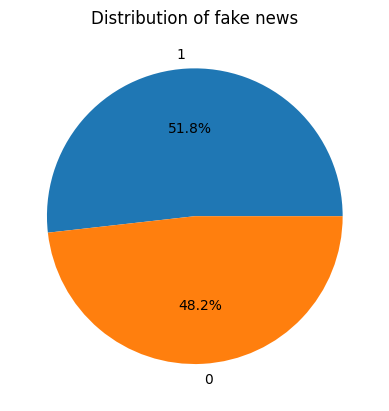

In [72]:

plt.pie(df['label'].value_counts(), labels=df['label'].unique(), autopct='%1.1f%%')
plt.title('Distribution of fake news')
plt.show()

#Observation: given data is relatively balanced 

In [73]:
#length of the text data
df['text_length']=df['text'].apply(lambda x: len(x))

In [74]:
df.head()

,title,text,label,text_length
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,5049
1,,Did they post their votes for Hillary already?,1,46
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,216
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,8010
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,1916


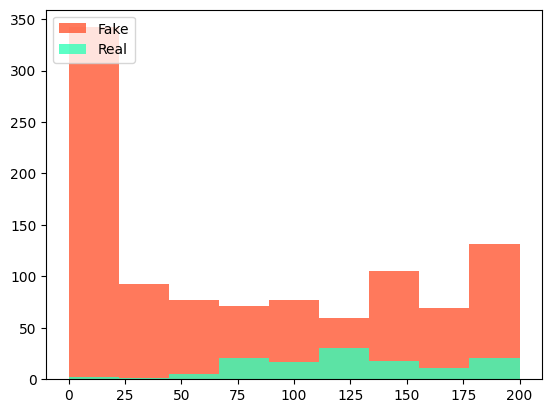

In [75]:
#news type and the length of the news
bins = np.linspace(0, 200, 10)

plt.hist(df[df["label"]== 1]["text_length"], bins, alpha=0.8, label="Fake", color="#FF5733")
plt.hist(df[df["label"]== 0]["text_length"], bins, alpha=0.8, label="Real", color="#33FFB8")
plt.legend(loc="upper left")
plt.show()

#most of fake news text is longer than the real one

In [76]:
#for further analysis we need only text data of the news,  drop another columns
df=df[:]

In [77]:
df=df.drop(['title','text_length'],axis=1)


In [78]:
df.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


# TextPreprocessing

In [79]:
from nltk.corpus import stopwords
from nltk.stem  import PorterStemmer
import re


In [80]:
stemmer=PorterStemmer()

In [122]:
def stemming(text):
    data=re.sub('[^a-zA-Z]',' ',text)
    data=data.lower()
    data=data.split()
    data=[stemmer.stem(word) for word in data  if not word in stopwords.words('english')]
    result="".join(data)
    return result 


    

In [123]:
text='hey there *4### , we are about to go'
stemming(text)

['hey', 'go']

In [124]:
df['processed_text']=df['text'].apply(stemming)

In [126]:
df.head()

,text,label,processed_text
0,No comment is expected from Barack Obama Membe...,1,"[comment, expect, barack, obama, member, fyf, ..."
1,Did they post their votes for Hillary already?,1,"[post, vote, hillari, alreadi]"
2,"Now, most of the demonstrators gathered last ...",1,"[demonstr, gather, last, night, exercis, const..."
3,A dozen politically active pastors came here f...,0,"[dozen, polit, activ, pastor, came, privat, di..."
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[rs, sarmat, missil, dub, satan, replac, ss, f..."


In [136]:
X=df['processed_text']
y=df['label']


AttributeError: 'Series' object has no attribute 'join'

In [128]:
X.shape

(30000,)

In [129]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=34)


In [130]:
X_train.shape

(24000,)

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [132]:
vectorizer=TfidfVectorizer()

In [135]:
X_train=vectorizer.fit_transform(X_train)
X_test=vectorizer.transform(X_test)

AttributeError: 'list' object has no attribute 'lower'

In [134]:
X_train


14060    [trump, loyal, subject, keep, bleat, mess, oba...
6106     [jakarta, reuter, indonesian, author, detain, ...
20808    [boston, reuter, new, hampshir, governor, magg...
961      [brussel, reuter, eu, brexit, negoti, michel, ...
17942    [open, letter, presid, obama, legendari, guita...
                               ...                        
28406    [charleston, c, juri, signal, friday, within, ...
22377    [go, anoth, activist, judg, shut, effort, pres...
10730    [two, way, analyz, donald, trump, decis, win, ...
5242     [london, reuter, turkey, crucial, tourism, sec...
11681    [washington, reuter, u, nation, secur, agenc, ...
Name: processed_text, Length: 24000, dtype: object

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
model=DecisionTreeClassifier()


In [ ]:
model.fit(X_train,y_train)

In [ ]:
y_pred=model.predict(X_test)

In [ ]:
model.score(y_test,y_pred)

In [ ]:
import pickle 


In [ ]:
pickle.dump(vectorizer,open('vectorizer.pkl','wb'))

In [ ]:
pickle.dump(model,open('model.pkl','wb'))

In [ ]:
vector=pickle.load(open('vectorizer.pkl','rb'))
loaded_model=pickle.load(open('model.pkl','rb'))

In [ ]:
def fake_news(news):
    news=stemming(news)
    input_data=[news]
    vector_form=vector.transform(input_data)
    prediction=loaded_model.predict(vector_form)
    return  prediction

In [ ]:
val=fake_news()

In [ ]:
if val==[0]:
    print('reliable')
else:
    print('fake')
    